## importando a base de dados nescessaria

In [1]:
!pip install mlforecast
!pip install lightgbm
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from typing import List
import pickle

import mlforecast
from mlforecast import MLForecast

from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate

from utilsforecast.plotting import plot_series

import lightgbm as lgb
from sklearn.base import BaseEstimator
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

from mlforecast import MLForecast
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
    AutoRandomForest,
    AutoXGBoost,
    AutoLinearRegression,
    AutoLasso,
    AutoElasticNet,
    AutoCatboost,
    xgboost_space,
    catboost_space,
    random_forest_space
)

import warnings
warnings.filterwarnings('ignore')

### Funções

In [3]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

## Importando a base de dados

In [4]:
bucket_uri = "gs://m5_dados/M5_full.parquet"

In [5]:
data = pd.read_parquet(bucket_uri)

In [6]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,value,date
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-05-22
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-05-22
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,2,2016-05-22
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,2016-05-22


In [7]:
data['id'].nunique()

30490

In [8]:
data['item_id'].nunique()

3049

In [9]:
data['dept_id'].nunique()

7

In [10]:
data['cat_id'].nunique()

3

In [11]:
data['store_id'].nunique()

10

In [12]:
data['state_id'].nunique()

3

In [13]:
data['date'] = pd.to_datetime(data['date'])

In [14]:
data = data.set_index('date')

## Previsão por loja (store_id):✅


In [15]:
df_store_id = data.groupby(['store_id']).resample('M')['value'].sum()

In [16]:
df_store_id.to_frame()

value
store_id date              
CA_1     2011-01-31   11308
         2011-02-28   89434
         2011-03-31   93468
         2011-04-30   91553
         2011-05-31   87988
...                     ...
WI_3     2016-01-31  113222
         2016-02-29  115407
         2016-03-31  119558
         2016-04-30  120175
         2016-05-31   94183

[650 rows x 1 columns]

In [17]:
df_store_id_reset_index = df_store_id.reset_index()

In [18]:
df_nixtla_5 = pd.DataFrame({
    'unique_id': df_store_id_reset_index['store_id'],
    'ds': df_store_id_reset_index['date'],
    'y': df_store_id_reset_index['value']
})

In [19]:
df_nixtla_5

,unique_id,ds,y
0,CA_1,2011-01-31,11308
1,CA_1,2011-02-28,89434
2,CA_1,2011-03-31,93468
3,CA_1,2011-04-30,91553
4,CA_1,2011-05-31,87988
...,...,...,...
645,WI_3,2016-01-31,113222
646,WI_3,2016-02-29,115407
647,WI_3,2016-03-31,119558
648,WI_3,2016-04-30,120175


In [20]:
df_nixtla_5['ds'] = pd.to_datetime(df_nixtla_5['ds'])

In [21]:
df_nixtla_5['unique_id'].value_counts().sum()

650

In [22]:
df_test = df_nixtla_5.groupby('unique_id').tail(6)
df_train = df_nixtla_5.drop(df_test.index)

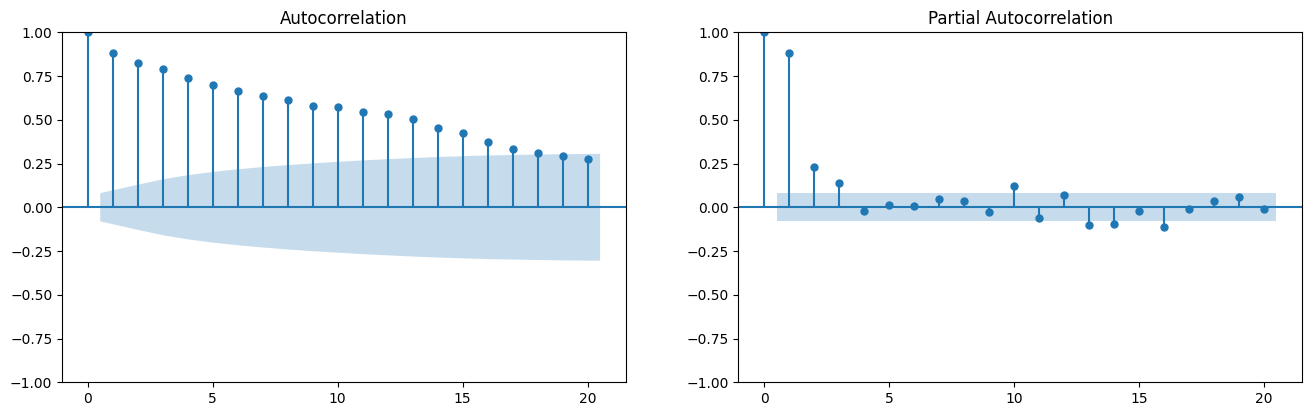

In [23]:
acf_pacf(df_train['y'], 20)

In [24]:
models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'MLPRegressor': MLPRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(),
    'LGBMRegressor': lgb.LGBMRegressor()
}

In [25]:
fcst = MLForecast(
    models=models,
    freq='M',
    lags=[x for x in range(1, 18)],
)

In [26]:
fcst.fit(df_train, id_col='unique_id', time_col='ds', target_col='y')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2397
[LightGBM] [Info] Number of data points in the train set: 420, number of used features: 17
[LightGBM] [Info] Start training from score 110097.804762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

MLForecast(models=[RandomForestRegressor, LinearRegression, MLPRegressor, KNeighborsRegressor, XGBRegressor, LGBMRegressor], freq=M, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17'], date_features=[], num_threads=1)

In [27]:
len(df_test)

60

In [28]:
predict = fcst.predict(6)


In [29]:
for i in list(models.keys()):
  predict[i] = predict[i].astype(int)

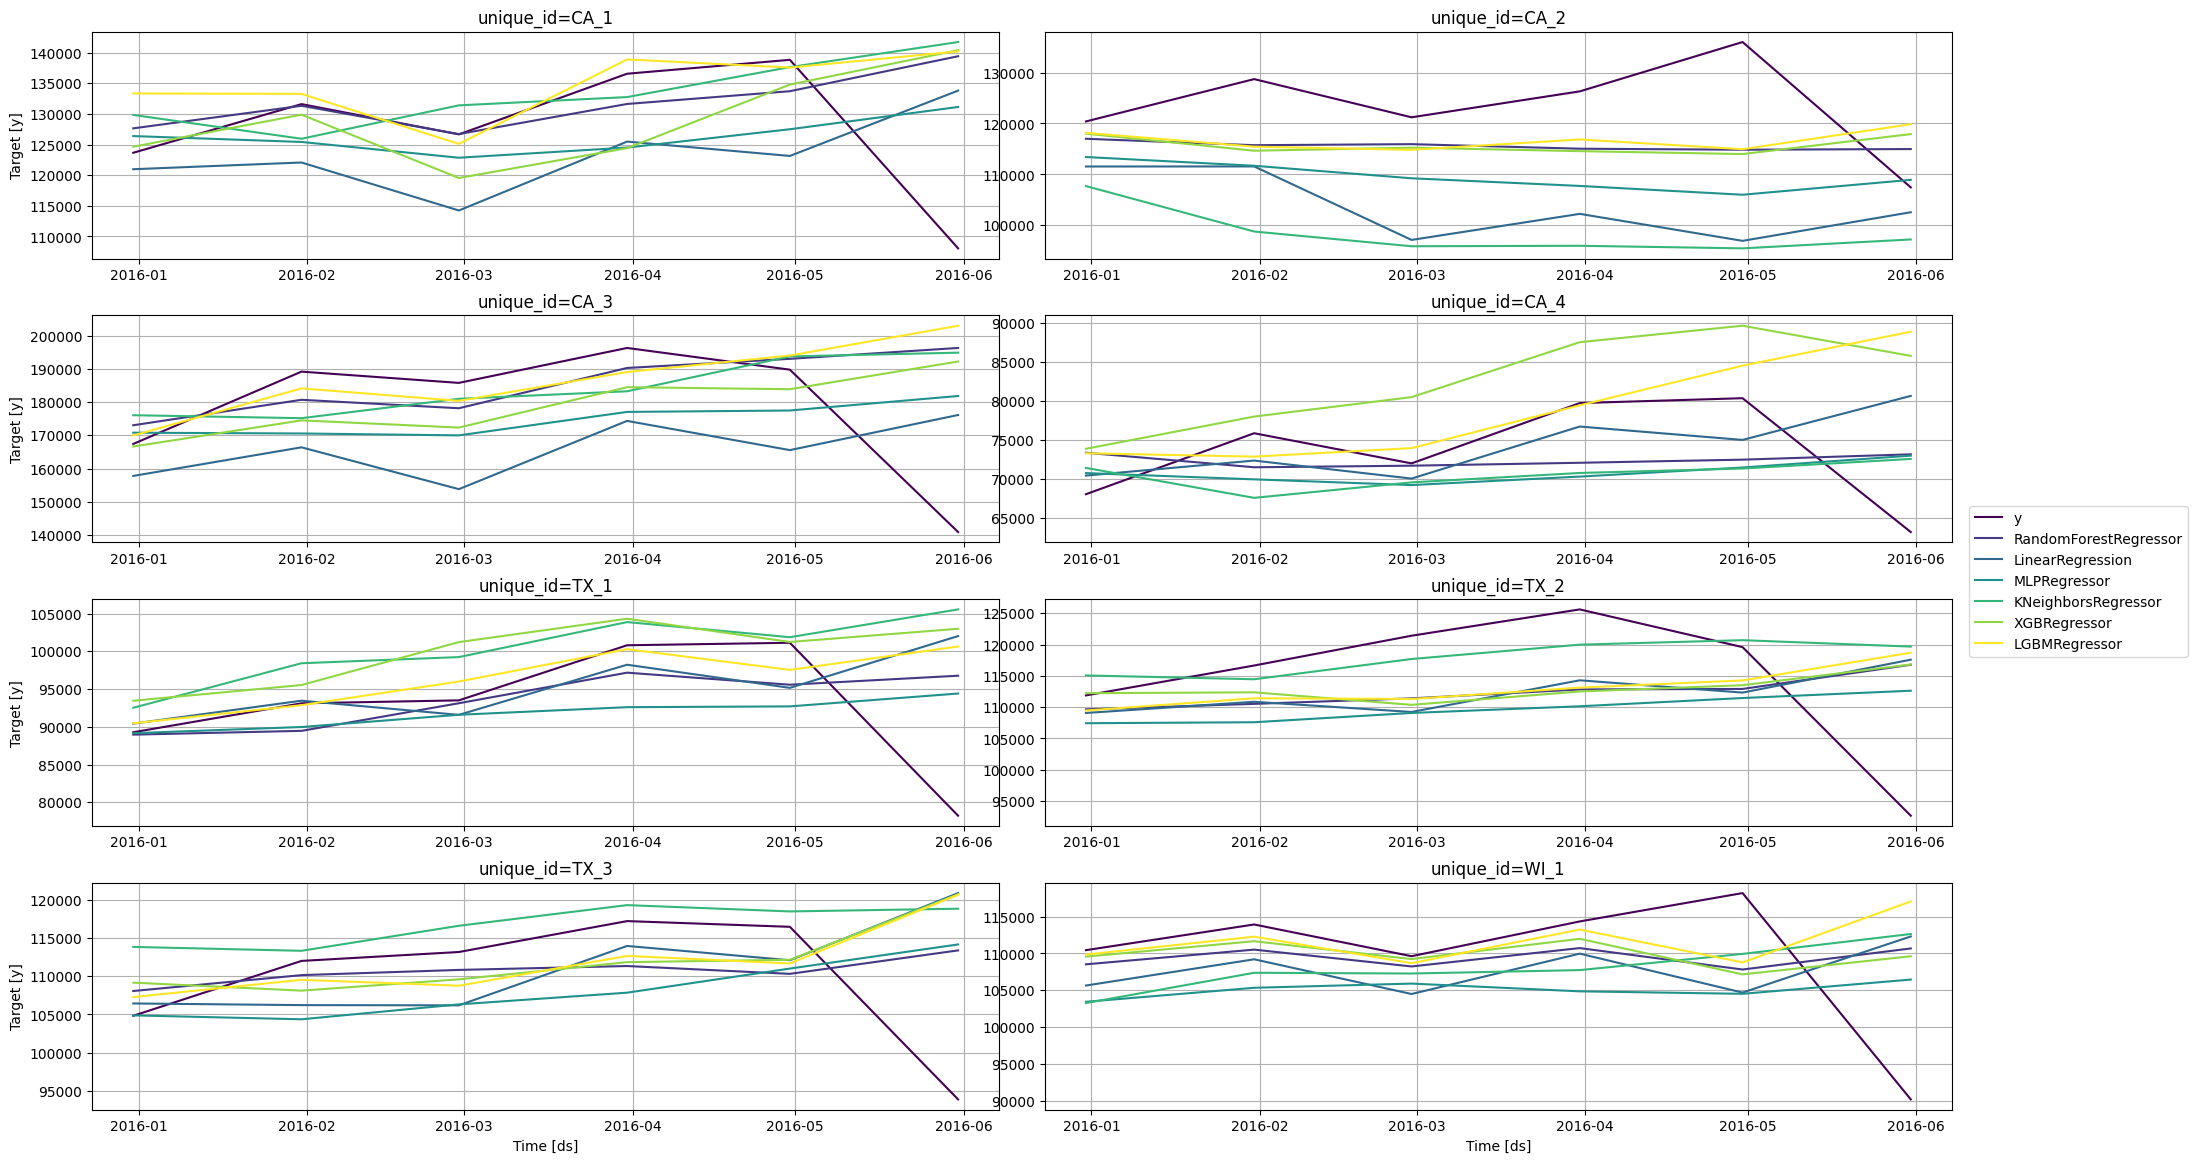

In [30]:
plot_series(df_test, predict, plot_random=False)

In [31]:
for i in list(models.keys()):
  print(f'------------------{i}-----------------')
  MAE = mean_absolute_error(df_test['y'], predict[i])
  print(f'Mean Absolute Error: {MAE}')

  MAPE = mean_absolute_percentage_error(df_test['y'], predict[i])
  print(f'Mean absolute percentage error: {MAPE}')

  RMSE = sqrt(mean_squared_error(df_test['y'], predict[i]))
  print(f'Root mean squared error: {RMSE}')

  R2 = r2_score(df_test['y'], predict[i])
  print(f'R2: {R2}')
  print('\n')

------------------RandomForestRegressor-----------------
Mean Absolute Error: 10123.383333333333
Mean absolute percentage error: 0.08573309567987326
Root mean squared error: 14947.748309249346
R2: 0.738077834270657


------------------LinearRegression-----------------
Mean Absolute Error: 13188.6
Mean absolute percentage error: 0.10753643552553367
Root mean squared error: 17341.868989048828
R2: 0.6474566703959559


------------------MLPRegressor-----------------
Mean Absolute Error: 11879.783333333333
Mean absolute percentage error: 0.0982771567070372
Root mean squared error: 15104.91239023473
R2: 0.732541058631555


------------------KNeighborsRegressor-----------------
Mean Absolute Error: 12572.616666666667
Mean absolute percentage error: 0.1065508346172787
Root mean squared error: 17875.465319351362
R2: 0.6254279122874106


------------------XGBRegressor-----------------
Mean Absolute Error: 11346.433333333332
Mean absolute percentage error: 0.09808140088775483
Root mean squared er

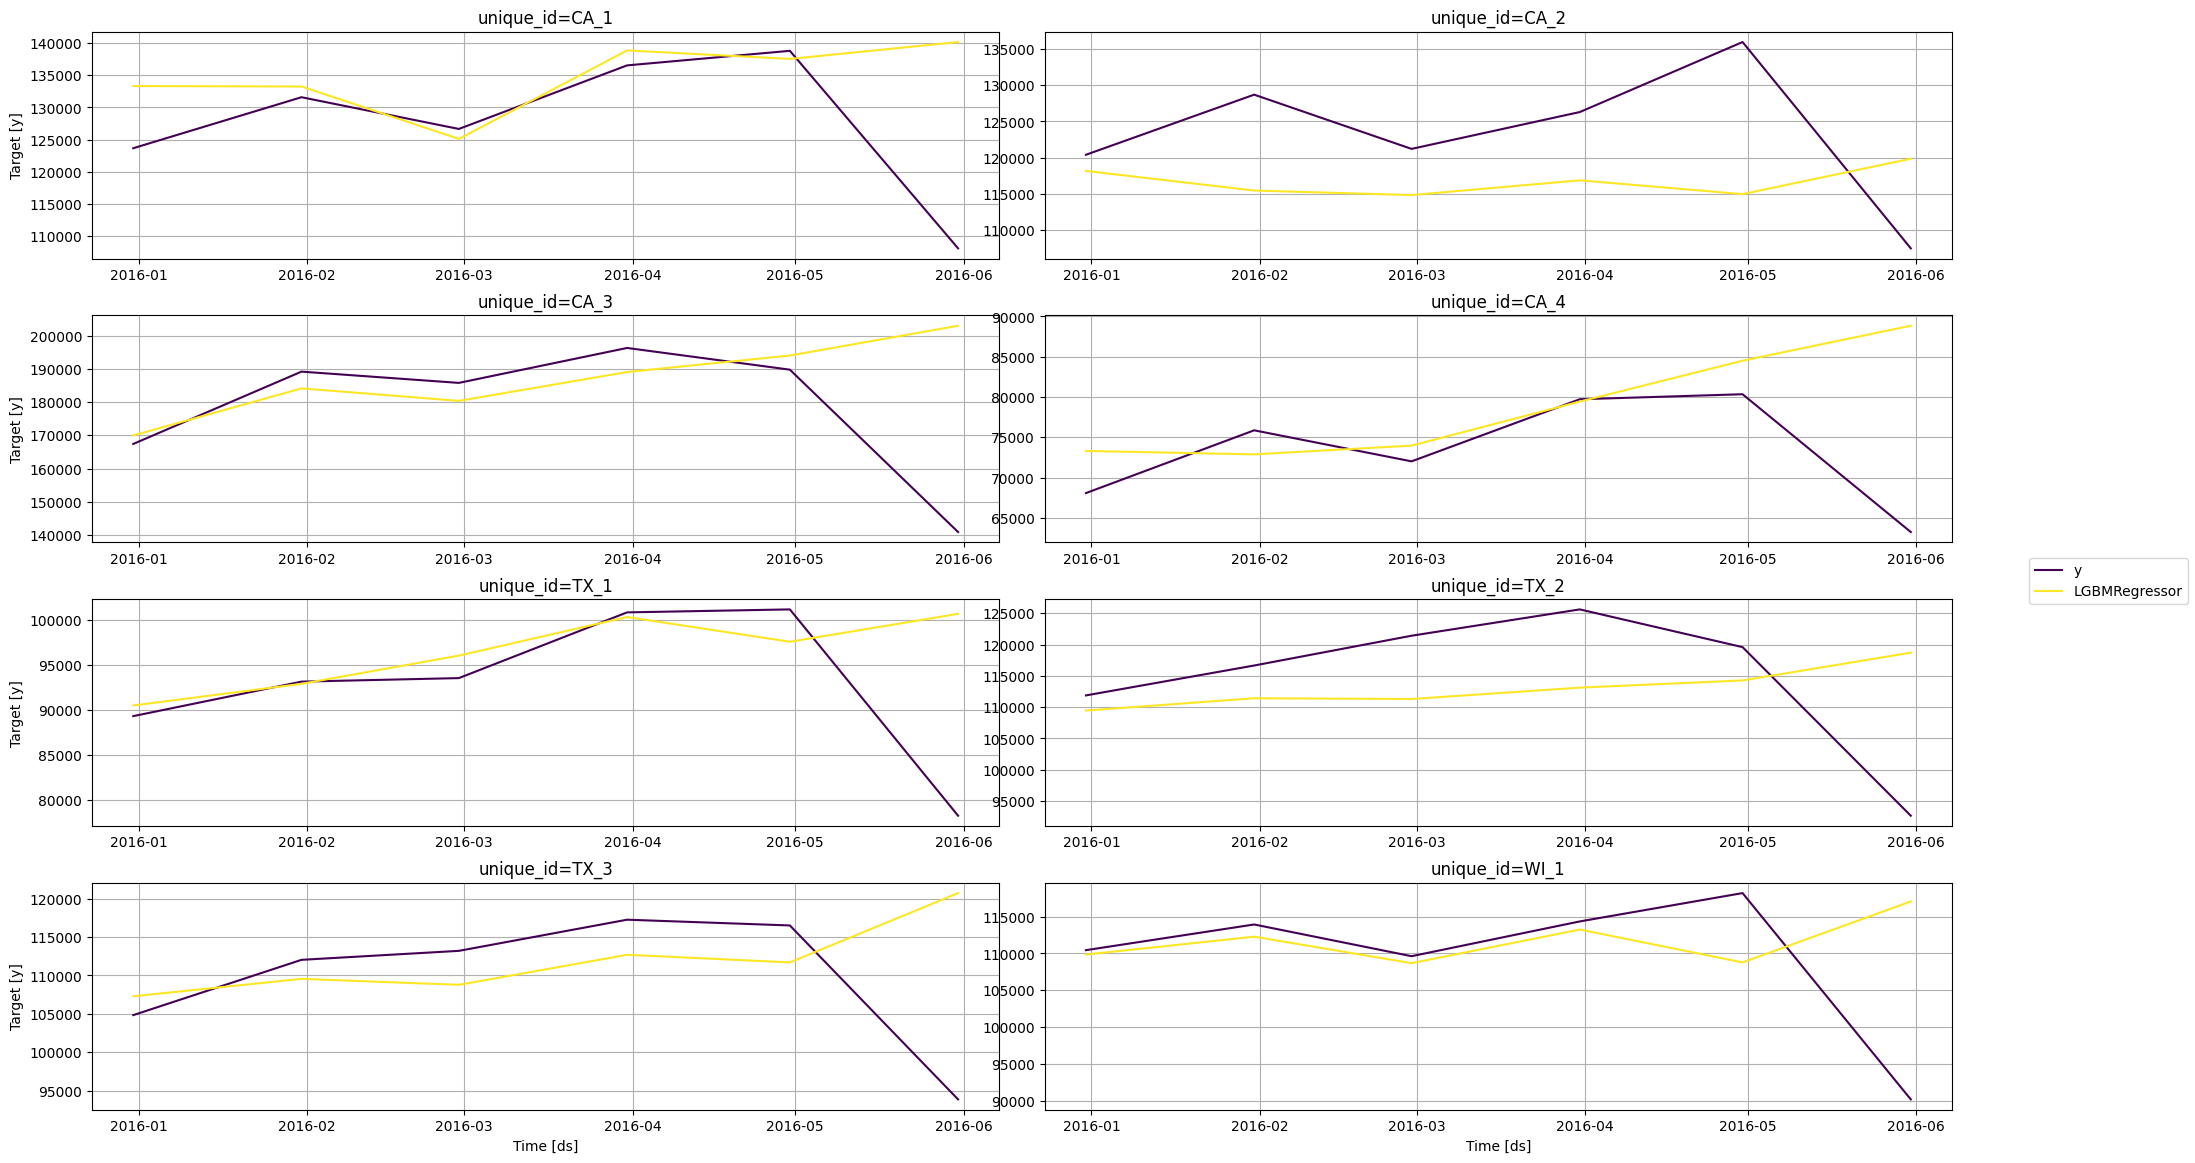

In [32]:
plot_series(df_test, predict[['unique_id', 'ds', 'LGBMRegressor']], plot_random=False)

In [33]:
metrics = [mae, rmse, mape]

previsao = df_test.merge(predict, how='right', on=['unique_id', 'ds'])
previsao.head()


,unique_id,ds,y,RandomForestRegressor,LinearRegression,MLPRegressor,KNeighborsRegressor,XGBRegressor,LGBMRegressor
0,CA_1,2015-12-31,123656,127642,120970,126382,129829,124647,133338
1,CA_1,2016-01-31,131598,131325,122067,125421,125942,129876,133266
2,CA_1,2016-02-29,126655,126709,114235,122845,131395,119542,125104
3,CA_1,2016-03-31,136557,131620,125482,124504,132747,124410,138887
4,CA_1,2016-04-30,138826,133703,123136,127496,137636,134783,137566


In [34]:
previsao.to_csv('treinamento/treino_lojas_treino.csv')

In [35]:
result_metrics = evaluate(
    df = previsao,
    metrics=metrics,
    models=list(models.keys()))


In [36]:
df_pivot = result_metrics.pivot(index='unique_id', columns='metric')
df_pivot.columns = [f'{col[1]}{col[0]}' for col in df_pivot.columns]
df_pivot.reset_index(inplace=True)

In [37]:
df_pivot

,unique_id,maeRandomForestRegressor,mapeRandomForestRegressor,rmseRandomForestRegressor,maeLinearRegression,mapeLinearRegression,rmseLinearRegression,maeMLPRegressor,mapeMLPRegressor,rmseMLPRegressor,maeKNeighborsRegressor,mapeKNeighborsRegressor,rmseKNeighborsRegressor,maeXGBRegressor,mapeXGBRegressor,rmseXGBRegressor,maeLGBMRegressor,mapeLGBMRegressor,rmseLGBMRegressor
0,CA_1,7622.166667,0.066337,13228.972869,12858.333333,0.104103,14629.320934,9862.000000,0.080417,12015.600900,9207.666667,0.079745,14391.180135,9726.500000,0.082443,14517.272706,8105.500000,0.071137,13778.326053
1,CA_2,10259.500000,0.081177,11815.313503,19665.000000,0.154644,22640.970054,14327.500000,0.111660,16961.498042,24822.166667,0.196577,26954.134992,11098.500000,0.088365,12709.642698,10791.166667,0.086503,12292.239252
2,CA_3,14422.500000,0.093560,23406.159357,24330.666667,0.140101,25672.557183,18405.333333,0.109658,21653.611392,16430.166667,0.103816,23818.388978,16341.500000,0.101813,23144.365877,14453.000000,0.095318,25815.738055
3,CA_4,5890.833333,0.081594,6651.223835,5588.500000,0.081140,7761.707447,6559.333333,0.089657,7203.843349,6880.666667,0.093867,7448.043121,9323.666667,0.133251,11273.155400,6700.333333,0.100540,10898.112987
4,TX_1,5348.500000,0.062503,8184.279555,5962.166667,0.071022,10119.434528,6333.833333,0.071222,8308.476184,7574.333333,0.090350,11756.178489,7120.000000,0.084680,10871.253163,5078.000000,0.061674,9344.787335
5,TX_2,10326.833333,0.095496,12469.950261,10719.666667,0.099206,12864.254843,11573.833333,0.104329,12643.622391,7146.500000,0.070644,11491.375599,9842.500000,0.091175,12474.546759,10273.166667,0.095834,12903.788120
6,TX_3,6513.333333,0.063323,8894.155722,8187.833333,0.080474,11886.906613,8297.000000,0.078882,10307.255115,7156.333333,0.071702,11028.297874,8075.500000,0.079620,11682.038128,7598.500000,0.075167,11525.920462
7,WI_1,6878.000000,0.067887,9656.559981,9122.666667,0.088397,11289.680878,9804.500000,0.092104,10647.441391,8912.333333,0.086895,10939.083005,6068.500000,0.060239,9242.068699,6773.333333,0.069412,11678.471133
8,WI_2,24346.166667,0.158734,28722.057572,24953.166667,0.162114,29827.745342,22076.500000,0.142819,26843.393821,26426.666667,0.172035,31322.081221,25543.833333,0.167502,29583.083508,25442.333333,0.166040,29978.309253
9,WI_3,9626.000000,0.086719,10385.736629,10498.000000,0.094162,11623.575454,11558.000000,0.102023,12636.264691,11169.333333,0.099877,12094.752430,10323.833333,0.091725,11444.136687,8797.666667,0.080279,9685.310475


In [38]:
best_models = {}

for metric in ['mae', 'mape', 'rmse']:
    best_models[metric] = []
    for idx, row in df_pivot.iterrows():
        min_value = float('inf')
        best_model = None
        for model in models:
            column_name = f'{metric}{model}'
            if row[column_name] < min_value:
                min_value = row[column_name]
                best_model = model
        best_models[metric].append(best_model)

best_models_df_pivot = pd.DataFrame(best_models)
best_models_df_pivot['unique_id'] = df_pivot['unique_id']

for i in ['mae', 'mape', 'rmse']:
  print(best_models_df_pivot[i].value_counts())

mae
RandomForestRegressor    4
LGBMRegressor            2
LinearRegression         1
KNeighborsRegressor      1
XGBRegressor             1
MLPRegressor             1
Name: count, dtype: int64
mape
RandomForestRegressor    4
LGBMRegressor            2
LinearRegression         1
KNeighborsRegressor      1
XGBRegressor             1
MLPRegressor             1
Name: count, dtype: int64
rmse
RandomForestRegressor    4
MLPRegressor             3
KNeighborsRegressor      1
XGBRegressor             1
LGBMRegressor            1
Name: count, dtype: int64


In [39]:
models = {
    'LGBMRegressor' : lgb.LGBMRegressor()
}

fcst = MLForecast(
    models=models,
    freq='MS',
    lags=[1, 6, 12]
)

In [40]:
dados_full = pd.concat([df_train, df_test])
fcst.fit(dados_full)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 531
[LightGBM] [Info] Number of data points in the train set: 530, number of used features: 3
[LightGBM] [Info] Start training from score 109567.147170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

MLForecast(models=[LGBMRegressor], freq=MS, lag_features=['lag1', 'lag6', 'lag12'], date_features=[], num_threads=1)

In [41]:
import pickle
with open('Modelos/modelo_previsao_lojas.pkl', 'wb') as file:
    pickle.dump(fcst, file)

In [42]:
previsao = fcst.predict(6)
previsao['LGBMRegressor'] = previsao['LGBMRegressor'].astype(int)
previsao

,unique_id,ds,LGBMRegressor
0,CA_1,2016-06-01,112295
1,CA_1,2016-07-01,116667
2,CA_1,2016-08-01,123465
3,CA_1,2016-09-01,132111
4,CA_1,2016-10-01,135201
5,CA_1,2016-11-01,128989
6,CA_2,2016-06-01,108862
7,CA_2,2016-07-01,110316
8,CA_2,2016-08-01,117262
9,CA_2,2016-09-01,117556


In [43]:
previsao.to_csv('previsao/previsao_lojas_RandomForestRegressor.csv')